<a href="https://colab.research.google.com/github/oshodiS/AII/blob/main/project_sho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

# 0. Importing libraries

In [1]:
colab = True

In [2]:
%%capture
if colab:
  !pip install fitter
  !pip install pydot
  !pip install graphviz

In [3]:
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

if colab:
  from fitter import Fitter
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import layers
  import tensorflow_probability as tfp
  from tensorflow.keras import callbacks

# 1. Load and inspect the dataset

In [4]:
if colab:
    # se con colab
    from pathlib import Path

    from google.colab import drive

    drive.mount('/content/drive')
    data_folder = Path.cwd() / "drive" / "MyDrive" / "A3I" / "data"
    dataset_path = data_folder.joinpath("AMS_descritt_noSM_meltD_adim.csv")
else:
    # se in locale
    dataset_path = "data/AMS_descritt_noSM_meltD_adim.csv"

df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

Mounted at /content/drive


,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [5]:
print(df.columns)

to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
df_cleaned = df.drop(to_remove, axis=1, inplace=False)

df_cleaned.head()

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1,1.221239,28.250000
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1,0.778761,28.250000
2,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,1.219018,33.469565
3,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,0.979995,33.469565
4,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,1.153287,33.469565


In [6]:
# Unique duration values
DURATION = df_cleaned['duration[h]'].unique()
print(DURATION)

[ 1  3  6 12 24]


## 1.1. Preprocess the dataset
spiegazione

In [7]:
# create a dictionary of dataframes, one for each duration
dfs = {}
for duration in DURATION:
    dfs[f'{duration}'] = df_cleaned[df_cleaned['duration[h]'] == duration].drop("duration[h]", axis=1, inplace=False)
    dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [8]:
dfs['3']

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1.106796,51.500000
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,0.893204,51.500000
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1.184466,51.500000
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,0.815534,51.500000
4,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,245.328628,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,0.876011,53.195652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54923,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,0.946180,37.836364
54924,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,1.009611,37.836364
54925,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,0.459875,37.836364
54926,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,1.009611,37.836364


In [9]:
# maximum value of AMS in each dataframe
for duration in DURATION:
    print(f"maximum AMS in {duration}h: {dfs[f'{duration}']['AMS'].max()}")

maximum AMS in 1h: 4.782464297575557
maximum AMS in 3h: 4.905896003540713
maximum AMS in 6h: 5.373404747735238
maximum AMS in 12h: 5.915663202234329
maximum AMS in 24h: 6.288661312900612


### scale the columns of the df

In [10]:
def scale_AMS(df, k = 1, IdD = True):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
        IdD: To specify how standardize. Defaults to True.
    """
    if IdD:
        df['AMS'] = df.apply(lambda row: row['AMS'] * row['IdD'], axis=1)

    min_AMS = df['AMS'].min() - 1e-3
    max_AMS = df['AMS'].max() * k

    df['AMS'] = df.apply(lambda row: (row['AMS'] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df

In [11]:
from sklearn.preprocessing import StandardScaler

features_not_to_scale = ['ID', 'AMS', 'mean_IdD']
features_to_scale = dfs['1'].columns.drop(features_not_to_scale)

order_columns = ['ID', 'AMS', 'mean_IdD'] + list(features_to_scale)

scaler = StandardScaler()
std_dfs = {}

for duration in DURATION:
    scaled_data = scaler.fit_transform(dfs[f'{duration}'][features_to_scale])
    non_scaled_data = dfs[f'{duration}'][features_not_to_scale]
    std_dfs[f'{duration}'] = np.concatenate([non_scaled_data, scaled_data], axis=1)

    # convert to dataframe
    std_dfs[f'{duration}'] = pd.DataFrame(std_dfs[f'{duration}'], columns=order_columns)

    # scale AMS
    std_dfs[f'{duration}'] = scale_AMS(std_dfs[f'{duration}'], IdD = False)

In [12]:
std_dfs['1']

,ID,AMS,mean_IdD,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001.0,0.255513,28.250000,1.493135,0.280734,0.145696,-0.374606,2.382053,0.223045,-0.501436,...,-0.884768,1.115122,0.961749,0.568256,2.186778,4.643091,1.809879,4.675577,0.433786,-0.801071
1,5001.0,0.163012,28.250000,1.493135,0.280734,0.145696,-0.374606,2.382053,0.223045,-0.501436,...,-0.884768,1.115122,0.961749,0.568256,2.186778,4.643091,1.809879,4.675577,0.433786,-0.801071
2,5002.0,0.255049,33.469565,-0.005096,-0.495027,-0.501910,-0.491656,1.348745,1.487395,0.086746,...,-1.101508,0.289555,-0.428596,-0.360073,1.048536,-0.366497,0.744075,-0.185518,-0.173668,-0.458617
3,5002.0,0.205080,33.469565,-0.005096,-0.495027,-0.501910,-0.491656,1.348745,1.487395,0.086746,...,-1.101508,0.289555,-0.428596,-0.360073,1.048536,-0.366497,0.744075,-0.185518,-0.173668,-0.458617
4,5002.0,0.241308,33.469565,-0.005096,-0.495027,-0.501910,-0.491656,1.348745,1.487395,0.086746,...,-1.101508,0.289555,-0.428596,-0.360073,1.048536,-0.366497,0.744075,-0.185518,-0.173668,-0.458617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54930,21338.0,0.208870,29.054545,-0.951571,-1.126087,-1.250470,-1.171791,-0.087880,0.158897,-1.074618,...,1.150882,-0.485477,0.461252,0.330717,-0.096168,-0.440606,-0.375153,-0.443278,0.933529,0.886966
54931,21338.0,0.151308,29.054545,-0.951571,-1.126087,-1.250470,-1.171791,-0.087880,0.158897,-1.074618,...,1.150882,-0.485477,0.461252,0.330717,-0.096168,-0.440606,-0.375153,-0.443278,0.933529,0.886966
54932,21338.0,0.119650,29.054545,-0.951571,-1.126087,-1.250470,-1.171791,-0.087880,0.158897,-1.074618,...,1.150882,-0.485477,0.461252,0.330717,-0.096168,-0.440606,-0.375153,-0.443278,0.933529,0.886966
54933,21338.0,0.200236,29.054545,-0.951571,-1.126087,-1.250470,-1.171791,-0.087880,0.158897,-1.074618,...,1.150882,-0.485477,0.461252,0.330717,-0.096168,-0.440606,-0.375153,-0.443278,0.933529,0.886966


In [13]:
if colab:
    # colab
    dataset_path = data_folder.joinpath("gumMap_statbench_Gumfit_NEW.csv")
else:
    #  locale
    dataset_path = "data/gumMap_statbench_Gumfit_NEW.csv"

df2 = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df2.head()

,Unnamed: 0,ID,Nome,md_1h,md_3h,md_6h,md_12h,md_24h,q1h_0.80,q1h_0.95,...,q_3h_0.99,q_6h_0.80,q_6h_0.95,q_6h_0.99,q_12h_0.80,q_12h_0.95,q_12h_0.99,q_24h_0.80,q_24h_0.95,q_24h_0.99
0,0,5005,'Anzola_Dellemilia',1.0,1.0,1.0,1.0,1.0,1.297268,1.770921,...,2.204652,1.262136,1.679814,2.142859,1.256130,1.664236,2.116671,1.257223,1.667072,2.121439
1,1,5007,'Argelato',1.0,1.0,1.0,1.0,1.0,1.307714,1.798013,...,2.270210,1.272879,1.707674,2.189696,1.264559,1.686097,2.153422,1.257970,1.669008,2.124694
2,2,5015,'Bardi_Centrale',1.0,1.0,1.0,1.0,1.0,1.271656,1.704500,...,2.174044,1.257236,1.667106,2.121495,1.251259,1.651604,2.095435,1.253316,1.656940,2.104405
3,3,5141,'Invaso',1.0,1.0,1.0,1.0,1.0,1.271679,1.704561,...,2.174045,1.257236,1.667106,2.121496,1.251259,1.651605,2.095436,1.253324,1.656960,2.104438
4,4,5143,'Isola_Di_Palanzano_Centrale',1.0,1.0,1.0,1.0,1.0,1.265930,1.689653,...,2.173967,1.257225,1.667077,2.121446,1.251233,1.651538,2.095324,1.250087,1.648565,2.090326


## 1.2. Train-Val-Test split

In [14]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df2['ID'].to_list()[:100]

test_dfs = {}
for duration in DURATION:
    test_dfs[f'{duration}'] = std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)]
    test_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [15]:
# Drop the test set from std_dfs and then create the train sets and validation sets
for duration in DURATION:
    std_dfs[f'{duration}'] = std_dfs[f'{duration}'].drop(std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)].index,)
    std_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

validation_split = 0.1

train_dfs = {}
val_dfs = {}
for duration in DURATION:
    train_dfs[f'{duration}'], val_dfs[f'{duration}'] = train_test_split(std_dfs[f'{duration}'], test_size=validation_split, shuffle=False)
    train_dfs[f'{duration}'].reset_index(drop=True, inplace=True)
    val_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [16]:
val_dfs['3']

,ID,AMS,mean_IdD,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,20034.0,0.147826,19.800000,1.388304,0.793990,0.723319,1.168153,-0.480947,0.091999,1.917337,...,1.149043,1.605276,3.068929,3.273526,-0.125320,1.505827,0.839188,1.687614,-1.847427,1.192438
1,20034.0,0.170540,19.800000,1.388304,0.793990,0.723319,1.168153,-0.480947,0.091999,1.917337,...,1.149043,1.605276,3.068929,3.273526,-0.125320,1.505827,0.839188,1.687614,-1.847427,1.192438
2,20034.0,0.143696,19.800000,1.388304,0.793990,0.723319,1.168153,-0.480947,0.091999,1.917337,...,1.149043,1.605276,3.068929,3.273526,-0.125320,1.505827,0.839188,1.687614,-1.847427,1.192438
3,20034.0,0.149891,19.800000,1.388304,0.793990,0.723319,1.168153,-0.480947,0.091999,1.917337,...,1.149043,1.605276,3.068929,3.273526,-0.125320,1.505827,0.839188,1.687614,-1.847427,1.192438
4,20034.0,0.257269,19.800000,1.388304,0.793990,0.723319,1.168153,-0.480947,0.091999,1.917337,...,1.149043,1.605276,3.068929,3.273526,-0.125320,1.505827,0.839188,1.687614,-1.847427,1.192438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,21338.0,0.190512,37.836364,-0.951971,-1.126756,-1.251120,-1.172737,-0.087368,0.157971,-1.074912,...,1.151300,-0.485863,0.460977,0.330544,-0.096763,-0.440808,-0.375600,-0.443570,0.933946,0.887384
5181,21338.0,0.203479,37.836364,-0.951971,-1.126756,-1.251120,-1.172737,-0.087368,0.157971,-1.074912,...,1.151300,-0.485863,0.460977,0.330544,-0.096763,-0.440808,-0.375600,-0.443570,0.933946,0.887384
5182,21338.0,0.091097,37.836364,-0.951971,-1.126756,-1.251120,-1.172737,-0.087368,0.157971,-1.074912,...,1.151300,-0.485863,0.460977,0.330544,-0.096763,-0.440808,-0.375600,-0.443570,0.933946,0.887384
5183,21338.0,0.203479,37.836364,-0.951971,-1.126756,-1.251120,-1.172737,-0.087368,0.157971,-1.074912,...,1.151300,-0.485863,0.460977,0.330544,-0.096763,-0.440808,-0.375600,-0.443570,0.933946,0.887384


## 1.3. Dataset inspection

#### Timeseries length distribution for each duration, both for training and validation

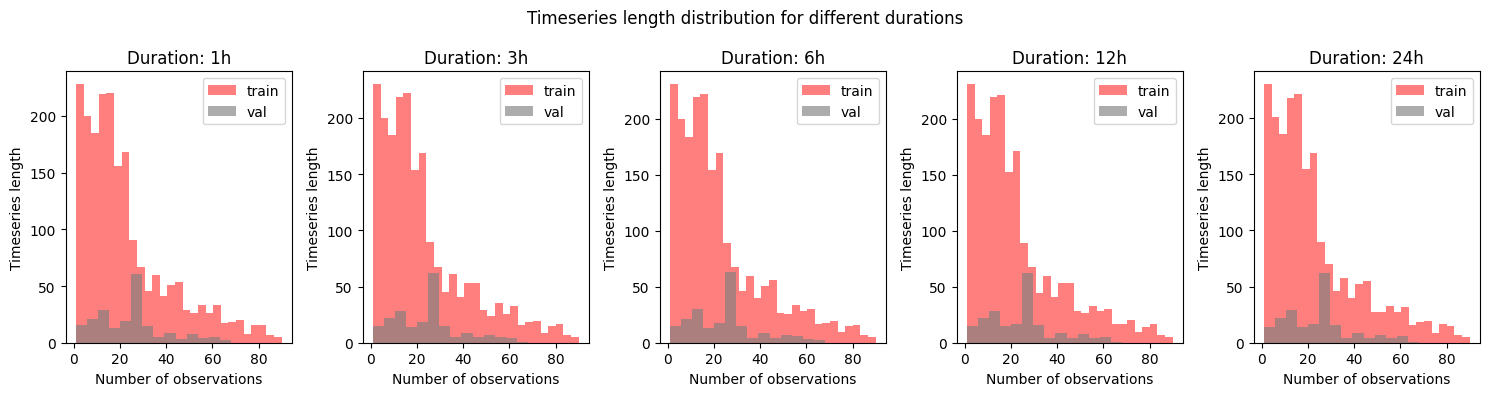

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns
fig.suptitle("Timeseries length distribution for different durations")

for i, duration in enumerate(DURATION):
    ax = axes[i]
    ax.hist(train_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.5, label='train', color='red')
    ax.hist(val_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.65, label='val', color='gray')
    ax.legend()
    ax.set_title(f"Duration: {duration}h")
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("Timeseries length")

plt.tight_layout()
plt.show()

### MAP distribution for training and validation

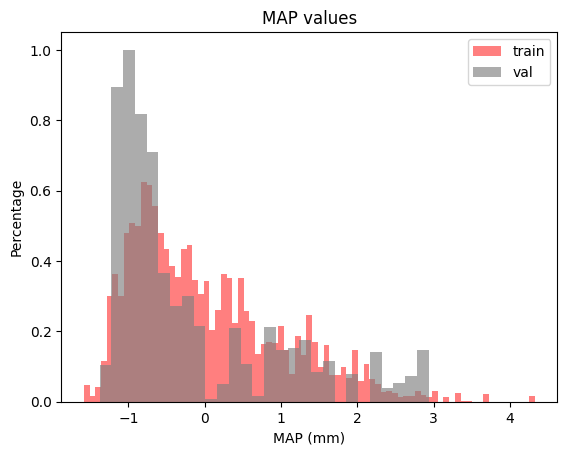

In [18]:
plt.hist(train_dfs['3']['MAP(mm)'], bins='auto', alpha=0.5, label='train', density=True, color='red')
plt.hist(val_dfs['3']['MAP(mm)'], bins='auto', alpha=0.65, label='val', density=True, color='gray')
plt.ylabel('Percentage')
plt.title('MAP values')
plt.xlabel('MAP (mm)')
plt.legend()
plt.show()

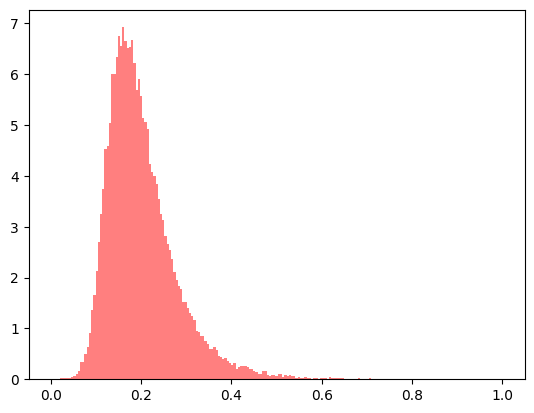

In [19]:
#create a global list of ams
#ams_global =  list(chain.from_iterable([train_dfs[duration]['AMS'] for duration in train_dfs]))

ams_3 = train_dfs['3']['AMS']

#plot the histogram
plt.hist(ams_3, bins='auto', alpha=0.5, label='train', density=True, color='red');

2024-01-24 17:34:48.305 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=9.876054)
2024-01-24 17:34:48.325 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=45.192028)
2024-01-24 17:34:48.341 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=345.214004)
2024-01-24 17:34:49.211 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=10.763044)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,9.876054,1104.441601,1130.693529,inf,0.042832,8.062810e-75
beta,10.763044,1180.804184,1215.806754,inf,0.045380,6.155047e-84
norm,45.192028,2420.247067,2437.748352,inf,0.092472,0.000000e+00
uniform,345.214004,3.959110,21.460395,inf,0.606170,0.000000e+00


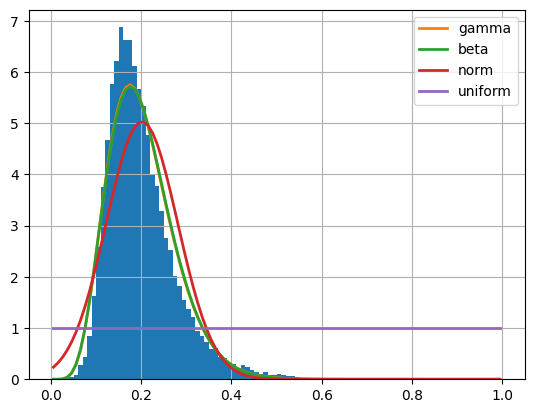

In [20]:
#Fit distribution
'''ams_global_np = np.array(ams_global)
f = Fitter(ams_global, distributions=['beta', 'gamma', 'norm', 'uniform'])'''
ams_1_np = np.array(ams_3)
f = Fitter(ams_3, distributions=['beta', 'gamma', 'norm', 'uniform'])
f.fit()
f.summary()

In [21]:
a_guess, b_guess, loc, scale  = f.fitted_param['beta']
print("alpha: ", a_guess)
print("beta: ", b_guess)

alpha:  7.254820357031425
beta:  175.98582887686695


## prepare data for training

In [22]:
print(train_dfs['3'].columns)

Index(['ID', 'AMS', 'mean_IdD', 'HMerit_mean(m)', 'HMerit_stdev(m)',
       'Slope_mean(deg)', 'Slope_stdev(deg)', 'Aspect_mean(deg)',
       'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)',
       'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)',
       'OrograTirr_mean(m)', 'OrograTirr_stdev(m)', 'OrograTirr_max(m)',
       'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [23]:
columns = train_dfs['1'].columns
input_columns = columns[3:]
output_column = 'AMS'
print('Input columns: ', input_columns)

Input columns:  Index(['HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [24]:
inputs_train = {}
outputs_train = {}
for duration in DURATION:
    inputs_train[f'{duration}'] = train_dfs[f'{duration}'][input_columns]
    outputs_train[f'{duration}'] = train_dfs[f'{duration}'][output_column]

inputs_val = {}
outputs_val = {}
for duration in DURATION:
    inputs_val[f'{duration}'] = val_dfs[f'{duration}'][input_columns]
    outputs_val[f'{duration}'] = val_dfs[f'{duration}'][output_column]

In [25]:
inputs_train['1']

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,1.493135,0.280734,0.145696,-0.374606,2.382053,0.223045,-0.501436,0.432007,0.617551,0.685623,-0.884768,1.115122,0.961749,0.568256,2.186778,4.643091,1.809879,4.675577,0.433786,-0.801071
1,1.493135,0.280734,0.145696,-0.374606,2.382053,0.223045,-0.501436,0.432007,0.617551,0.685623,-0.884768,1.115122,0.961749,0.568256,2.186778,4.643091,1.809879,4.675577,0.433786,-0.801071
2,-0.005096,-0.495027,-0.501910,-0.491656,1.348745,1.487395,0.086746,0.076408,0.422520,0.229879,-1.101508,0.289555,-0.428596,-0.360073,1.048536,-0.366497,0.744075,-0.185518,-0.173668,-0.458617
3,-0.005096,-0.495027,-0.501910,-0.491656,1.348745,1.487395,0.086746,0.076408,0.422520,0.229879,-1.101508,0.289555,-0.428596,-0.360073,1.048536,-0.366497,0.744075,-0.185518,-0.173668,-0.458617
4,-0.005096,-0.495027,-0.501910,-0.491656,1.348745,1.487395,0.086746,0.076408,0.422520,0.229879,-1.101508,0.289555,-0.428596,-0.360073,1.048536,-0.366497,0.744075,-0.185518,-0.173668,-0.458617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46660,1.388720,0.794396,0.723945,1.168385,-0.481524,0.092910,1.917189,0.718284,1.647261,1.950205,1.148625,1.605909,3.069101,3.273685,-0.124727,1.506971,0.839615,1.689210,-1.847244,1.191941
46661,1.388720,0.794396,0.723945,1.168385,-0.481524,0.092910,1.917189,0.718284,1.647261,1.950205,1.148625,1.605909,3.069101,3.273685,-0.124727,1.506971,0.839615,1.689210,-1.847244,1.191941
46662,1.388720,0.794396,0.723945,1.168385,-0.481524,0.092910,1.917189,0.718284,1.647261,1.950205,1.148625,1.605909,3.069101,3.273685,-0.124727,1.506971,0.839615,1.689210,-1.847244,1.191941
46663,1.388720,0.794396,0.723945,1.168385,-0.481524,0.092910,1.917189,0.718284,1.647261,1.950205,1.148625,1.605909,3.069101,3.273685,-0.124727,1.506971,0.839615,1.689210,-1.847244,1.191941


In [26]:
X_train = inputs_train['3'].values
y_train  = outputs_train['3'].values

In [27]:
batch_size = 1

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
train_dataset = train_dataset.batch(batch_size)

In [29]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 20), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [30]:
def build_nn_beta_model(input_shape, hidden, alpha_guess=1, beta_guess=1):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)
    alpha_beta = layers.Dense(2, activation='linear')(x)

    lf = lambda t: tfp.distributions.Beta(concentration0= tf.math.exp( t[:,0:1] ), concentration1=tf.math.exp(t[:,1:2] ), validate_args=True, allow_nan_stats=True)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

In [31]:
type(a_guess)

numpy.float64

In [32]:
from math import nan
epochs = 3
optimizer=keras.optimizers.Adam(learning_rate=1e-3)
model = build_nn_beta_model(input_shape=(20,), hidden=[], alpha_guess=a_guess, beta_guess=b_guess)
loss_fn = lambda y_true, dist: -dist.log_prob(y_true)





for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.

            try:
             logits = model(x_batch_train, training=True)  # Logits for this minibatch
            except:
              print(step)
              print()
              print("CAZZO DI LOSS ------------------")
              print(loss_value)
            # Compute the loss value for this minibatch.


            loss_value = loss_fn(tf.cast(y_batch_train, tf.float32), logits)


        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        # if step % 200 == 0:
        #     print( (step, loss_value)
        #     )
            #print("Seen so far: %d samples" % ((step + 1) * batch_size))




Start of epoch 0
24486

CAZZO DI LOSS ------------------
tf.Tensor([[inf]], shape=(1, 1), dtype=float32)


ValueError: No gradients provided for any variable: (['dense/kernel:0', 'dense/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense/kernel:0' shape=(20, 2) dtype=float32, numpy=
array([[        nan,  0.0085349 ],
       [        nan, -0.4758185 ],
       [        nan, -0.03851082],
       [        nan, -0.25204843],
       [        nan,  0.13167402],
       [        nan, -0.1803597 ],
       [        nan,  0.08056287],
       [        nan,  0.25673327],
       [        nan,  0.03165287],
       [        nan, -0.14829953],
       [        nan, -0.3887713 ],
       [        nan, -0.32480952],
       [        nan,  0.01142807],
       [        nan, -0.10531346],
       [        nan,  0.17014803],
       [        nan,  0.07782072],
       [        nan, -0.24936174],
       [        nan,  0.10387897],
       [        nan,  0.5098563 ],
       [        nan,  0.25715253]], dtype=float32)>), (None, <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([     nan, 0.986021], dtype=float32)>)).

In [ ]:
tf.keras.backend.set_floatx('float32')

In [ ]:
def plot_nn_model(model):
    return keras.utils.plot_model(model, show_shapes=True,
            show_layer_names=True, rankdir='LR', show_layer_activations=True)

In [ ]:
import datetime

In [ ]:
def train_nn_model(model, X, y, loss, validation_data=None, verbose=True, patience=5, epochs=1, batch_size=1):
    # Compile the model
    optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss=loss)
    # Build the early stop callback
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    cb = []
    if validation_data is not None:
        cb += [callbacks.EarlyStopping(patience=patience,restore_best_weights=True)]
    # Train the model
    history = model.fit(X, y, callbacks=[cb, tensorboard_callback],
            validation_data=validation_data,
            verbose=verbose, epochs=epochs, batch_size=batch_size)
    return history

In [ ]:
def plot_training_history(history=None,
        figsize=None, print_final_scores=True):
    plt.figure(figsize=figsize)
    for metric in history.history.keys():
        plt.plot(history.history[metric], label=metric)
    # if 'val_loss' in history.history.keys():
    #     plt.plot(history.history['val_loss'], label='val. loss')
    if len(history.history.keys()) > 0:
        plt.legend()
    plt.xlabel('epochs')
    plt.grid(linestyle=':')
    plt.tight_layout()
    plt.show()
    if print_final_scores:
        trl = history.history["loss"][-1]
        s = f'Final loss: {trl:.4f} (training)'
        if 'val_loss' in history.history:
            vll = history.history["val_loss"][-1]
            s += f', {vll:.4f} (validation)'
        print(s)

In [ ]:
plot_nn_model(nnb)


In [ ]:
#nnb = build_nn_beta_model(input_shape=len(input_columns), hidden=[16, 8], alpha_guess=a_guess, beta_guess=b_guess)
nnb = build_nn_beta_model(input_shape=(5,), hidden=[], alpha_guess=a_guess, beta_guess=b_guess)


history = train_nn_model(nnb, pca_inputs_train['3'], outputs_train['3'], loss=negloglikelihood, batch_size=8, epochs=3)
plot_training_history(history, figsize=(9, 3))


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit